C:\Users\vinaygandhi\AppData\Local\anaconda3\envs\tf1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-19 09:20:39,493] A new study created in memory with name: no-name-af643953-17c5-4158-9ac0-90d7d225a99d
[I 2025-04-19 09:20:49,803] Trial 0 finished with value: 0.014104698784649372 and parameters: {'lam': 0.0012894907519001152, 'lr': 0.023493636517030354, 'num_epoch': 2000}. Best is trial 0 with value: 0.014104698784649372.
[I 2025-04-19 09:22:14,566] Trial 1 finished with value: 0.0029720175080001354 and parameters: {'lam': 0.0049765707771699235, 'lr': 0.1333533151010355, 'num_epoch': 15000}. Best is trial 1 with value: 0.0029720175080001354.
[I 2025-04-19 09:22:25,009] Trial 2 finished with value: 0.013791070319712162 and parameters: {'lam': 0.00894024852670445, 'lr': 0.016457086755752862, 'num_epoch'

Best trial:
FrozenTrial(number=62, state=TrialState.COMPLETE, values=[0.0018176974263042212], datetime_start=datetime.datetime(2025, 4, 19, 10, 31, 35, 688523), datetime_complete=datetime.datetime(2025, 4, 19, 10, 33, 3, 451174), params={'lam': 0.001204807885393672, 'lr': 0.0519488857195382, 'num_epoch': 15000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lam': FloatDistribution(high=0.01, log=True, low=0.001, step=None), 'lr': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'num_epoch': CategoricalDistribution(choices=(2000, 5000, 10000, 15000))}, trial_id=62, value=None)
Test MSE: 0.001964
Test R² : 0.955056
Test Acc: 0.9500


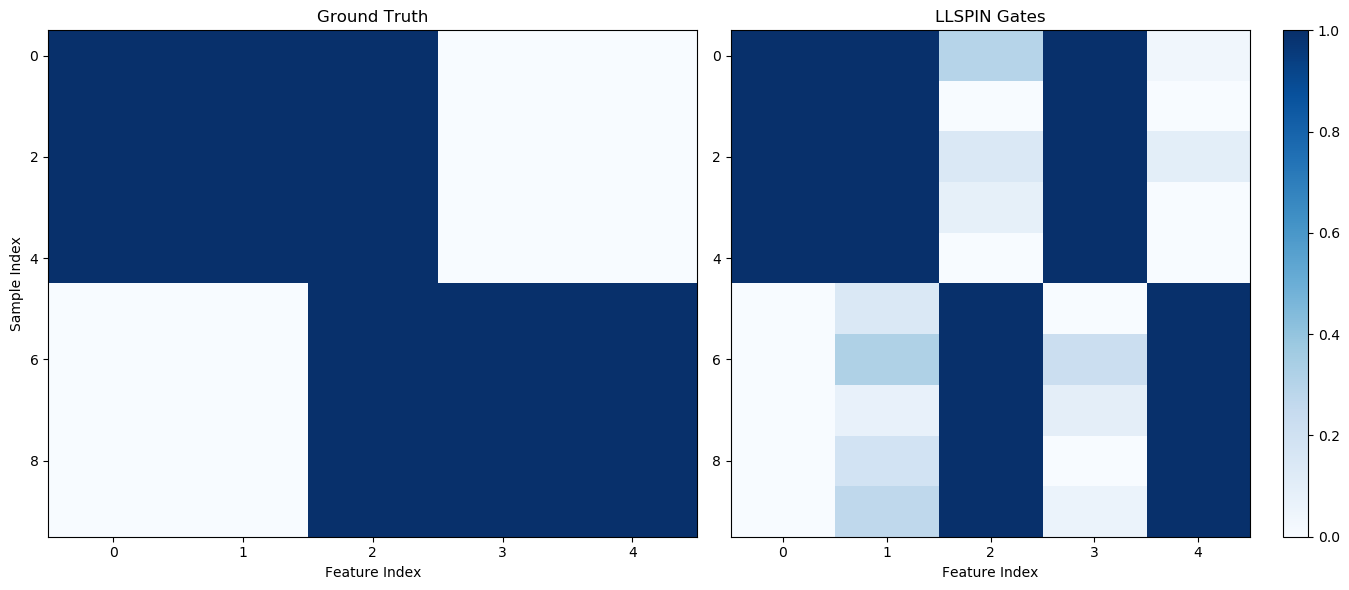

In [4]:
# llspin_pytorch.py
# Full 1-to-1 PyTorch implementation of the LLSPIN model using updated 5-feature synthetic equation and batch gradient descent

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os
import random
import optuna

# -----------------------------
# 0. Set seed for reproducibility
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(32)

# -----------------------------
# 1. Updated Synthetic Data Generation
# -----------------------------
def linear_simple_data_gen(n_sample=300, seed=42):
    rng = np.random.default_rng(seed)
    Xs1 = rng.normal(loc=1, scale=0.5, size=(n_sample, 5))
    Ys1 = -2 * Xs1[:, 0] + 1 * Xs1[:, 1] - 0.5 * Xs1[:, 2]
    Xs2 = rng.normal(loc=-1, scale=0.5, size=(n_sample, 5))
    Ys2 = -0.5 * Xs2[:, 2] + 1 * Xs2[:, 3] - 2 * Xs2[:, 4]

    X_data = np.concatenate((Xs1, Xs2), axis=0)
    Y_data = np.concatenate((Ys1.reshape(-1, 1), Ys2.reshape(-1, 1)), axis=0)
    Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())
    labels = np.concatenate((np.ones(n_sample), np.full(n_sample, 2)))
    Y_data = np.concatenate((Y_data, labels.reshape(-1, 1)), axis=1)
    return X_data.astype(np.float32), Y_data.astype(np.float32)

# ----------------------
# 2. LLSPIN Components (included here for execution)
# ----------------------
class HardSigmoid(nn.Module):
    def __init__(self, a):
        super().__init__()
        self.a = a
    def forward(self, x):
        return torch.clamp(self.a * x + 0.5, 0., 1.)

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, a, sigma):
        super().__init__()
        self.a = a
        self.sigma = sigma
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        self.hidden = nn.Sequential(*layers)
        self.alpha_layer = nn.Linear(last_dim, input_dim)
        self.hard_sigmoid = HardSigmoid(a)
    def forward(self, x, is_training=True):
        alpha = self.alpha_layer(self.hidden(x))
        if is_training:
            noise = torch.randn_like(alpha) * self.sigma
            z = alpha + noise
            gate = self.hard_sigmoid(z)
        else:
            gate = self.hard_sigmoid(alpha)
        return gate, alpha

class PredictionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers[:-1]:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.Tanh())
            last_dim = h
        layers.append(nn.Linear(last_dim, hidden_layers[-1]))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

class LSPIN(nn.Module):
    def __init__(self, input_dim, pred_hidden, output_dim, gate_hidden, a, sigma, lam, feature_selection=True):
        super().__init__()
        self.feature_selection = feature_selection
        self.a = a
        self.sigma = sigma
        self.lam = lam
        if self.feature_selection:
            self.gating_net = GatingNetwork(input_dim, gate_hidden, a, sigma)
        self.pred_net = PredictionNetwork(input_dim, pred_hidden, output_dim)
        self.loss_fn = nn.MSELoss()
    def forward(self, x, y=None, train_gates=True):
        if self.feature_selection:
            gates, alpha = self.gating_net(x, is_training=train_gates)
            x = x * gates
        else:
            alpha = None
        logits = self.pred_net(x)
        output = {'logits': logits, 'alpha': alpha}
        if y is not None:
            output['loss'] = self.loss_fn(logits, y)
        return output
    def get_prob_alpha(self, x):
        with torch.no_grad():
            _, alpha = self.gating_net(x, is_training=False)
            return self.gating_net.hard_sigmoid(alpha).cpu().numpy()

# ----------------------------
# 3. Optuna-Compatible Training Loop 
# ----------------------------
def train_llspin_with_params(lam, lr, num_epoch):
    X_data, Y_data = linear_simple_data_gen()
    X_train, X_remain, yc_train, yc_remain = train_test_split(X_data, Y_data, train_size=0.8, random_state=42)
    X_valid, X_test, yc_valid, yc_test = train_test_split(X_remain, yc_remain, train_size=0.5, random_state=42)
    X_train, _, yc_train, _ = train_test_split(X_train, yc_train, train_size=10, random_state=42)

    y_train = yc_train[:, 0:1]
    y_valid = yc_valid[:, 0:1]
    y_test = yc_test[:, 0:1]
    train_label = yc_train[:, 1]

    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)

    model = LSPIN(
        input_dim=5,
        pred_hidden=[100, 100, 10, 1],
        output_dim=1,
        gate_hidden=[10],
        a=1,
        sigma=0.5,
        lam=lam
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epoch):
        model.train()
        output = model(X_train_tensor, y_train_tensor, train_gates=True)
        loss = output['loss']
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(torch.tensor(X_valid), torch.tensor(y_valid), train_gates=False)
        val_loss = val_output['loss'].item()

    return val_loss, model, (X_test, y_test, train_label, X_train_tensor)

# ----------------------------
# 4. Optuna Objective Function
# ----------------------------
def optuna_objective(trial):
    lam = trial.suggest_float('lam', 1e-3, 1e-2, log=True)
    lr = trial.suggest_float('lr', 1e-2, 2e-1, log=True)
    num_epoch = trial.suggest_categorical('num_epoch', [2000, 5000, 10000, 15000])
    val_loss, _, _ = train_llspin_with_params(lam, lr, num_epoch)
    return val_loss

# ----------------------------
# 5. Run Optuna Study
# ----------------------------
def run_optuna_study():
    study = optuna.create_study(direction="minimize")
    study.optimize(optuna_objective, n_trials=100)
    print("Best trial:")
    print(study.best_trial)

    # Re-train the best model
    best_params = study.best_trial.params
    val_loss, model, (X_test, y_test, train_label, X_train_tensor) = train_llspin_with_params(
        best_params['lam'], best_params['lr'], best_params['num_epoch']
    )

    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test))['logits'].cpu().numpy()
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        acc = np.mean((y_pred > 0.5).astype(int) == (y_test > 0.5).astype(int))
        print(f"Test MSE: {mse:.6f}\nTest R² : {r2:.6f}\nTest Acc: {acc:.4f}")

    gate_mat_train = model.get_prob_alpha(X_train_tensor)
    ref_feat_mat_train = np.array([[1, 1, 1, 0, 0] if lbl == 1 else [0, 0, 1, 1, 1] for lbl in train_label])
    sorted_order = np.concatenate((np.where(train_label == 1)[0], np.where(train_label == 2)[0]))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    cmap = cm.Blues
    norm = colors.BoundaryNorm([0, 0.5, 1], cmap.N)

    axes[0].imshow(ref_feat_mat_train[sorted_order], aspect='auto', cmap=cmap, norm=norm)
    axes[0].set_title("Ground Truth")
    axes[0].set_xlabel("Feature Index")
    axes[0].set_ylabel("Sample Index")

    im2 = axes[1].imshow(gate_mat_train[sorted_order], aspect='auto', cmap=cmap)
    axes[1].set_title("LLSPIN Gates")
    axes[1].set_xlabel("Feature Index")

    plt.colorbar(im2, ax=axes[1])
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_optuna_study()
